# Jupyter notebook for debugging

In [2]:
%load_ext autoreload
%autoreload 2

# Copied from `train` function in train_simple.py:L78
import yaml


device = 'cpu'
hyp = 'data/hyps/hyp.scratch-med.yaml'

with open(hyp, errors="ignore") as f:
    hyp = yaml.safe_load(f)  # load hyps dict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
!pip install opencv-python

  Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (63.0 MB)


In [25]:
from models.yolo import Model
from utils.general import check_dataset

cfg = 'models/yolov5x6_kaist-rgbt.yaml'
data = 'data/kaist-rgbt.yaml'
data_dict = check_dataset(data)

nc = int(data_dict["nc"])  # number of classes
model = Model(cfg, ch=3, nc=nc, anchors=hyp.get("anchors")).to(device)  # create


                 from  n    params  module                                  arguments                     
  0                -1  1     17600  models.common.MultiStreamConv           [3, 80, 6, 2, 2]              
  1                -1  1    231040  models.common.MultiStreamConv           [80, 160, 3, 2]               
  2                -1  4    618240  models.common.MultiStreamC3             [160, 160, 4]                 
  3                -1  1         0  models.common.Fusion                    ['concat', 2]                 
  4                -1  1    922240  models.common.Conv                      [320, 320, 3, 2]              
  5                -1  8   2259200  models.common.C3                        [320, 320, 8]                 
  6                -1  1   1844480  models.common.Conv                      [320, 640, 3, 2]              
  7                -1 12  13125120  models.common.C3                        [640, 640, 12]                
  8                -1  1   5531520  

In [26]:
model.model[-1].anchors

tensor([[[ 3.00000,  6.50000],
         [ 3.25000,  8.87500],
         [ 4.37500, 11.62500]],

        [[ 2.56250,  7.43750],
         [ 6.43750,  4.75000],
         [ 3.06250,  9.18750]],

        [[ 1.90625,  5.81250],
         [ 5.75000,  2.59375],
         [ 8.25000,  2.40625]],

        [[ 1.17188,  3.75000],
         [ 6.59375,  1.07812],
         [ 1.40625,  4.79688]]])

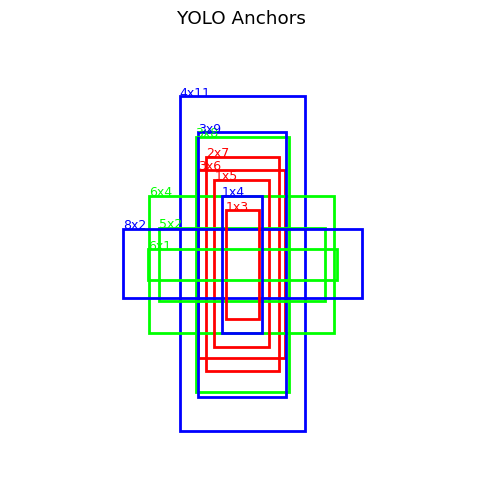

In [27]:
anchors = model.model[-1].anchors

# [TODO] Draw anchors
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

scale = 20  # anchor 크기를 확대할 배율
img_size = 320  # 전체 이미지 사이즈를 줄임
canvas = np.ones((img_size, img_size, 3), dtype=np.uint8) * 255

nl, na = anchors.shape[:2]
colors = [(255,0,0), (0,255,0), (0,0,255), (255,0,255), (0,255,255)]

plt.figure(figsize=(6, 6))
plt.imshow(canvas)
for i in range(nl):
    for j in range(na):
        w, h = anchors[i, j] * scale  # 👈 anchor 크기 확대
        w, h = int(w), int(h)
        x1 = img_size // 2 - w // 2
        y1 = img_size // 2 - h // 2
        rect = plt.Rectangle((x1, y1), w, h, linewidth=2,
                             edgecolor=np.array(colors[j % len(colors)])/255,
                             facecolor='none')
        plt.gca().add_patch(rect)
        plt.text(x1, y1, f'{int(anchors[i,j,0])}x{int(anchors[i,j,1])}',
                 color=np.array(colors[j % len(colors)])/255,
                 fontsize=9)
plt.title("YOLO Anchors")
plt.axis('off')
plt.show()

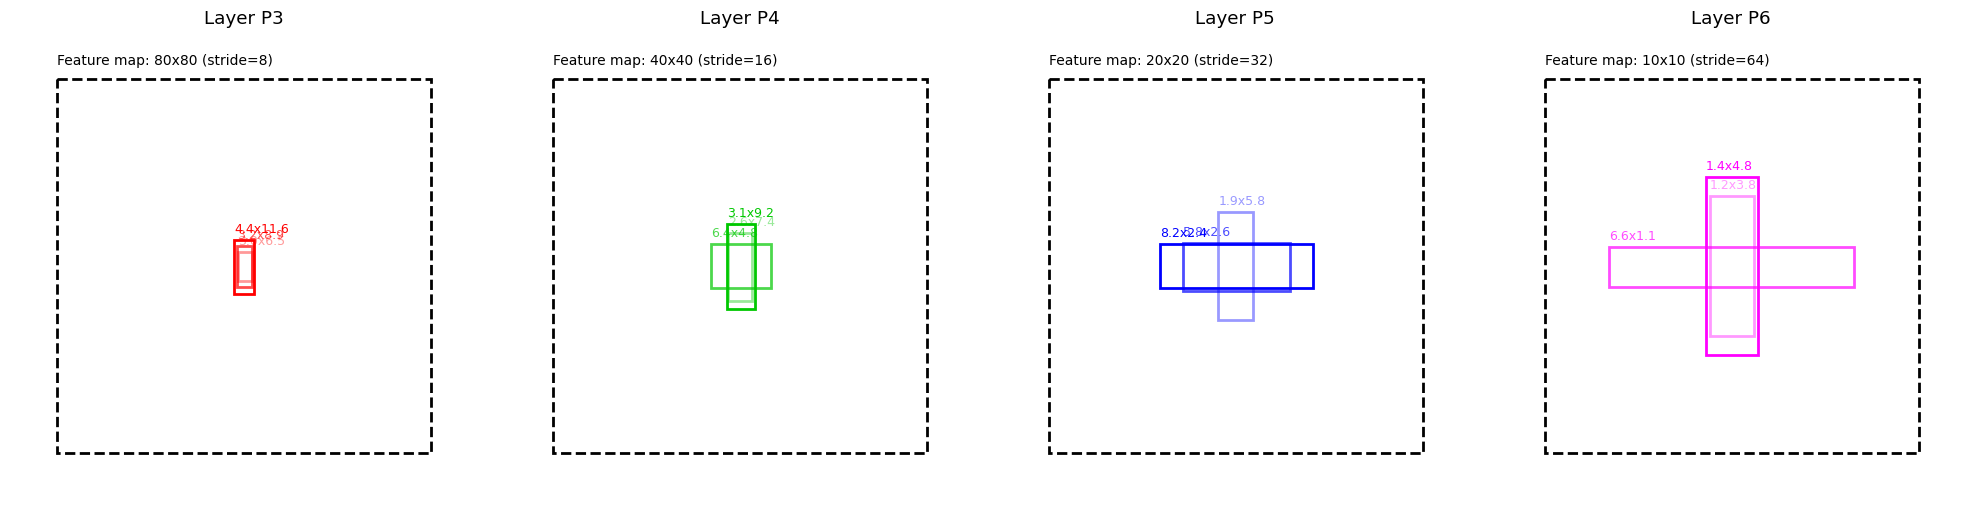

In [29]:
import numpy as np
import matplotlib.pyplot as plt

anchors = model.model[-1].anchors  # shape: (nl, na, 2)
strides = model.model[-1].stride.cpu().numpy()

input_imgsz = 640  # 입력 이미지 크기
img_size = 320     # 시각화 캔버스 사이즈 (캔버스 자체 크기)
nl, na = anchors.shape[:2]

# 색상 정의 → 초록색 조금 더 진하게 수정 (0,200,0)
colors = [
    (255, 0, 0),   # 빨강
    (0, 200, 0),   # 진한 초록
    (0, 0, 255),   # 파랑
    (255, 0, 255), # 보라
    (0, 255, 255)  # 청록
]

fig, axs = plt.subplots(1, nl, figsize=(5 * nl, 5))

# 투명도 단계 설정
alpha_levels = np.linspace(0.4, 1.0, na)

# 레이어명 → P3~P6로 매핑
pyramid_names = ['P3', 'P4', 'P5', 'P6']

# feature map 사이즈 계산
feature_map_sizes = (input_imgsz / strides).astype(int)

# Feature map 박스 고정 크기 → 모두 동일한 크기로 표시 (전체 캔버스의 80% 정도 사용)
fixed_box_scale = 0.8
fixed_box_size = img_size * fixed_box_scale

for i in range(nl):
    ax = axs[i]
    canvas = np.ones((img_size, img_size, 3), dtype=np.uint8) * 255
    ax.imshow(canvas)

    stride = strides[i]
    feature_map_size = feature_map_sizes[i]

    # Feature map 박스 동일한 크기로 표시
    fx1 = img_size // 2 - fixed_box_size // 2
    fy1 = img_size // 2 - fixed_box_size // 2

    # 한 cell당 크기 (px) → 동일한 박스에 표시하기 위해 feature map cell 크기 계산
    cell_size = fixed_box_size / feature_map_size

    rect_fmap = plt.Rectangle((fx1, fy1), fixed_box_size, fixed_box_size,
                              linewidth=2, edgecolor='black', facecolor='none', linestyle='--')
    ax.add_patch(rect_fmap)

    # Feature map size 텍스트
    ax.text(fx1, fy1 - 10, f'Feature map: {feature_map_size}x{feature_map_size} (stride={int(stride)})',
            color='black', fontsize=10)

    # Anchor box 그리기 (feature map 좌표계 기준으로 정확히 표시)
    for j in range(na):
        # feature map 셀 단위 anchor 크기
        w_cell = anchors[i, j, 0]
        h_cell = anchors[i, j, 1]

        # feature map 박스 안에서 anchor 박스 크기 (px 단위로 변환)
        w = w_cell * cell_size
        h = h_cell * cell_size

        w, h = int(w), int(h)
        x1 = img_size // 2 - w // 2
        y1 = img_size // 2 - h // 2

        rect = plt.Rectangle((x1, y1), w, h, linewidth=2,
                             edgecolor=np.array(colors[i % len(colors)]) / 255,
                             facecolor='none',
                             alpha=alpha_levels[j])
        ax.add_patch(rect)

        # 텍스트는 "feature map 셀 단위 anchor 크기" 그대로 → "cells" 단어는 빼고
        ax.text(x1, y1 - 5, f'{anchors[i,j,0]:.1f}x{anchors[i,j,1]:.1f}',
                color=np.array(colors[i % len(colors)]) / 255,
                fontsize=9,
                alpha=alpha_levels[j])

    ax.set_title(f'Layer {pyramid_names[i]}')
    ax.axis('off'

)

plt.tight_layout()
plt.show()


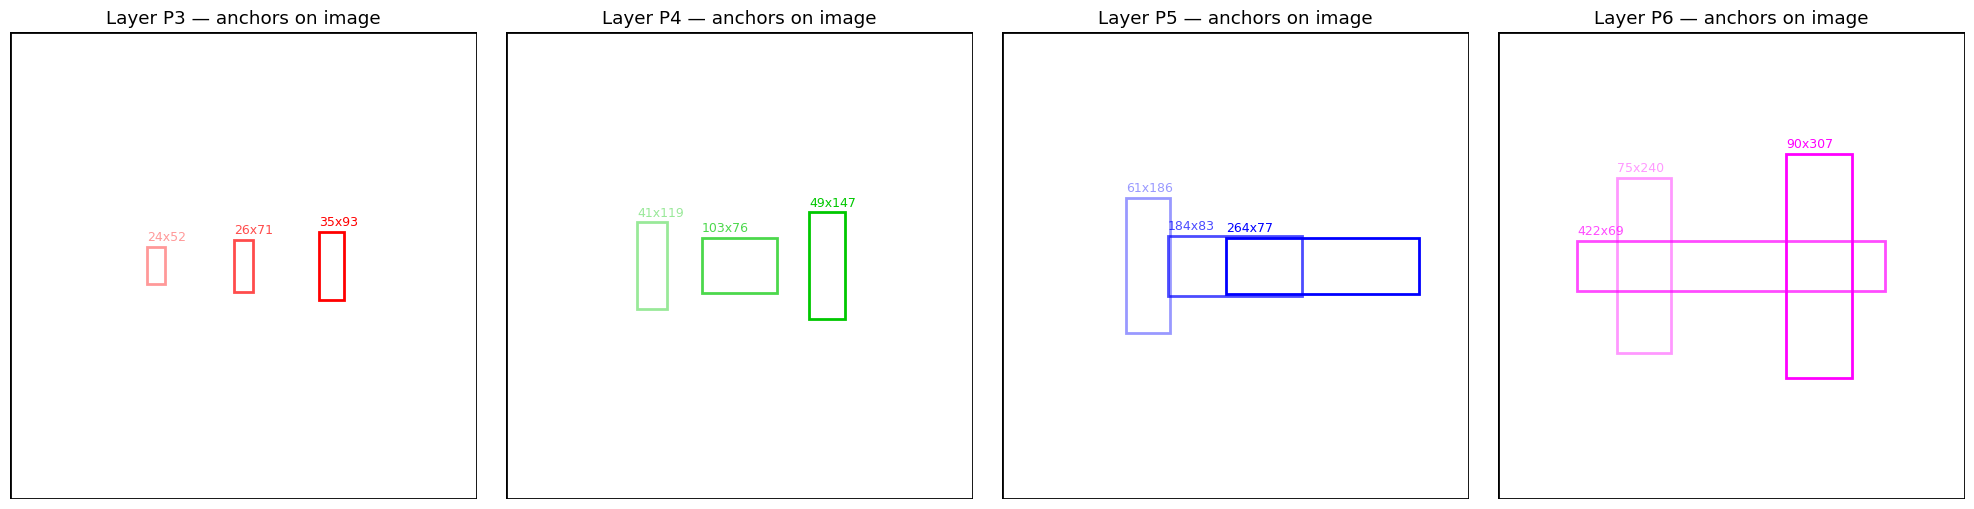

In [30]:
import numpy as np
import matplotlib.pyplot as plt

anchors = model.model[-1].anchors  # shape: (nl, na, 2)
strides = model.model[-1].stride.cpu().numpy()

input_imgsz = 640  # 입력 이미지 크기
nl, na = anchors.shape[:2]

# 색상 정의 → 초록색 조금 더 진하게 수정 (0,200,0)
colors = [
    (255, 0, 0),   # 빨강
    (0, 200, 0),   # 진한 초록
    (0, 0, 255),   # 파랑
    (255, 0, 255), # 보라
    (0, 255, 255)  # 청록
]

fig, axs = plt.subplots(1, nl, figsize=(5 * nl, 5))

# 투명도 단계 설정
alpha_levels = np.linspace(0.4, 1.0, na)

# 레이어명 → P3~P6로 매핑
pyramid_names = ['P3', 'P4', 'P5', 'P6']

# Anchor 배치용 spacing (중앙 정렬되게 조정)
x_spacing = 120  # 너비 조절해서 보기 좋은 간격으로 배치
y_position = input_imgsz // 2  # 높이는 고정

for i in range(nl):
    ax = axs[i]
    # 원본 이미지 크기 캔버스 (흰색 배경)
    canvas = np.ones((input_imgsz, input_imgsz, 3), dtype=np.uint8) * 255
    ax.imshow(canvas)

    # 검정색 테두리 박스 그리기
    rect_border = plt.Rectangle((0, 0), input_imgsz, input_imgsz,
                                linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(rect_border)

    # 오른쪽 잘림 방지 → axis 고정
    ax.set_xlim([0, input_imgsz])
    ax.set_ylim([input_imgsz, 0])  # y축 반전 (이미지 좌상단 기준으로 보기 좋게)

    stride = strides[i]

    # 중앙 정렬 배치용 → 시작 위치 계산
    total_width = (na - 1) * x_spacing
    start_x = (input_imgsz // 2) - (total_width // 2)

    # Anchor box 그리기
    for j in range(na):
        # 원본 이미지 기준 anchor 크기 (px)
        w_pixel = anchors[i,j,0] * stride
        h_pixel = anchors[i,j,1] * stride

        # 좌우로 중앙 정렬 배치
        x1 = start_x + j * x_spacing - w_pixel // 2
        y1 = y_position - h_pixel // 2

        rect = plt.Rectangle((x1, y1), w_pixel, h_pixel, linewidth=2,
                             edgecolor=np.array(colors[i % len(colors)]) / 255,
                             facecolor='none',
                             alpha=alpha_levels[j])
        ax.add_patch(rect)

        # 글씨는 pixel 단위로 표시
        ax.text(x1, y1 - 8, f'{int(w_pixel)}x{int(h_pixel)}',
                color=np.array(colors[i % len(colors)]) / 255,
                fontsize=9,
                alpha=alpha_levels[j])

    ax.set_title(f'Layer {pyramid_names[i]} — anchors on image')
    ax.axis('off'

)

plt.tight_layout()
plt.show()


## Sanity check: dataset
- Read images and label
- Visualize bounding boxes

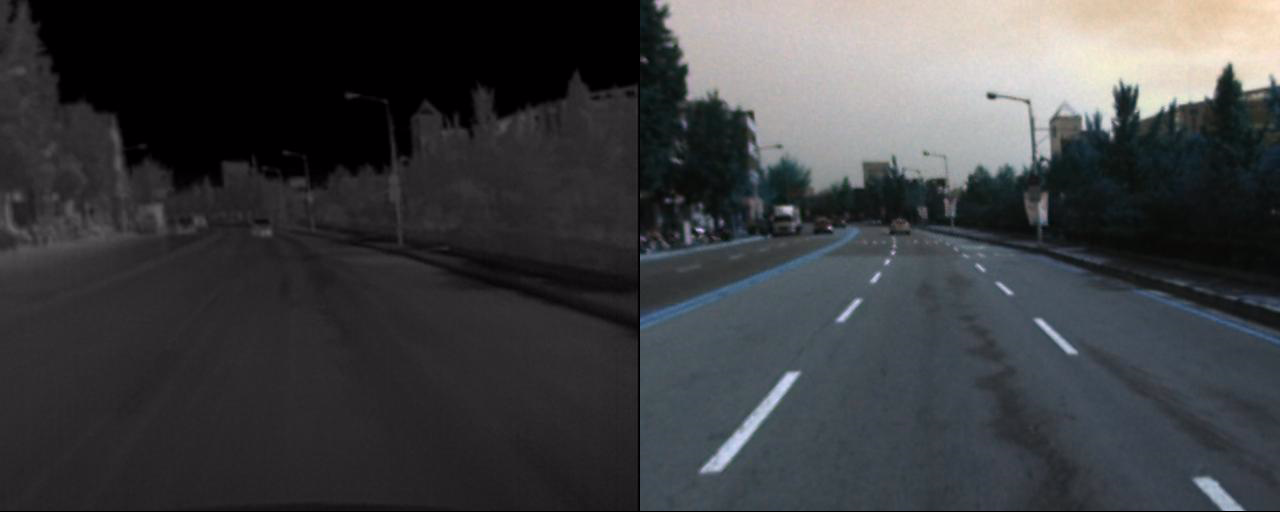

In [33]:
import cv2
import os
import numpy as np
from PIL import Image

annFile = 'datasets/kaist-rgbt/train/labels/set01_V002_I00723.txt'
lwirFile = annFile.replace('labels', 'images/lwir').replace('.txt', '.jpg')
visFile  = annFile.replace('labels', 'images/visible').replace('.txt', '.jpg')

# Read images
img_lwir = cv2.imread(lwirFile)
img_vis  = cv2.imread(visFile)

h, w = img_vis.shape[:2]

# Read labels
with open(annFile, 'r') as fp:
    labels = [x.split() for x in fp.read().strip().splitlines() if len(x)]

colors = {
    0: (255, 0, 0),
    1: (0, 255, 0),
    2: (0, 0, 255),
    3: (255, 0, 255),
}

if len(labels):
    # convert normalized bbox to pixel coordinates
    labels = np.array(labels, dtype=np.float32)
    labels[:, (1, 3)] *= w
    labels[:, (2, 4)] *= h

    cls = labels[:, 0]

    xyxy = np.zeros((len(labels), 4))
    xyxy[:, :2] = labels[:, 1:3]
    xyxy[:, 2:] = labels[:, 1:3] + labels[:, 3:5]
    xyxy = xyxy.astype(np.int16)

    for c, bb in zip(cls, xyxy):
        color = colors[c]
        cv2.rectangle(img_lwir, bb[:2], bb[2:], color)
        cv2.rectangle(img_vis,  bb[:2], bb[2:], color)

images = np.concatenate([img_lwir, img_vis], axis=1)
Image.fromarray(images)

## Sanity check: dataset class
- Visualize bounding boxes from dataset class

In [6]:
from utils.dataloaders import create_dataloader
from utils.general import check_img_size, colorstr

imgsz = 640
batch_size = 1
single_cls = False
seed = 0

train_path = data_dict["train"]
print(train_path)
gs = max(int(model.stride.max()), 32)  # grid size (max stride)
imgsz = check_img_size(imgsz, gs, floor=gs * 2)  # verify imgsz is gs-multiple

train_loader, dataset = create_dataloader(
    train_path,
    imgsz,
    batch_size,
    gs,
    single_cls,
    hyp=hyp,
    augment=False,      # TODO: check if there is no bug when applying augmentation
    cache=None,
    rect=False,
    rank=-1,
    workers=8,
    image_weights=False,
    quad=False,
    prefix=colorstr("train: "),
    shuffle=False,      # No shuffle for debugging
    seed=seed,
    rgbt_input=True,
)


['/home/cv/jw/kaist-rgbt/train.txt']


train: Scanning /home/cv/jw/kaist-rgbt/train.cache... 10030 images, 5607 backgrounds, 0 corrupt: 100%|██████████| 10030/10030 [00:00<?, ?it/s]


datasets/kaist-rgbt/train/images/{}/set00_V002_I01191.jpg


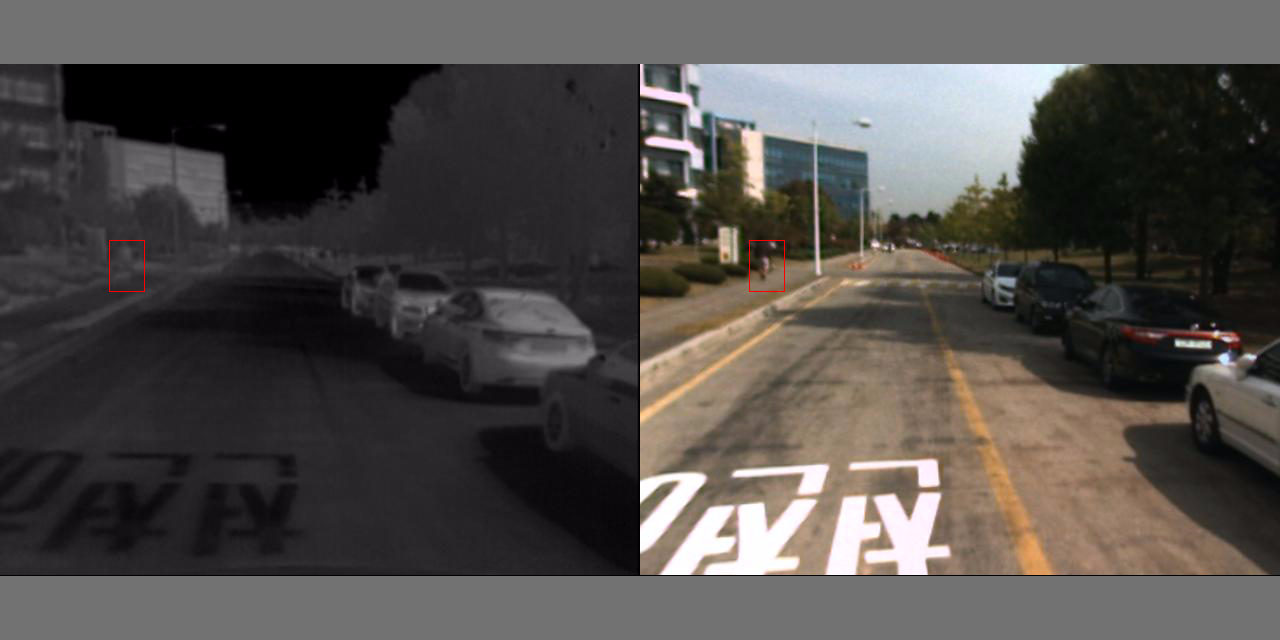

In [7]:
from utils.dataloaders import LoadRGBTImagesAndLabels
from utils.general import xywh2xyxy

frame = 1219  # frame index in the dataset

# Get a minibatch
# for ii, (imgs, targets, paths, _) in enumerate(train_loader):
#     break

# Get a minibatch (fast)
imgs, targets, paths, shapes, _ = LoadRGBTImagesAndLabels.collate_fn([dataset[frame]])

idx = 0
img_lwir = imgs[0][idx].numpy().transpose((1, 2, 0))
img_vis  = imgs[1][idx].numpy().transpose((1, 2, 0))
h, w = img_vis.shape[:2]

labels = targets.numpy()

colors = {
    0: (255, 0, 0),
    1: (0, 255, 0),
    2: (0, 0, 255),
    3: (255, 0, 255),
}

if len(labels):
    labels = labels[labels[:, 0] == idx, 1:]

    # convert normalized bbox to pixel coordinates
    labels = np.array(labels, dtype=np.float32)
    labels[:, (1, 3)] *= w
    labels[:, (2, 4)] *= h

    cls = labels[:, 0]

    xyxy = xywh2xyxy(labels[:, 1:5])
    xyxy = xyxy.astype(np.int16)

    img_lwir = np.ascontiguousarray(img_lwir)
    img_vis = np.ascontiguousarray(img_vis)

    for c, bb in zip(cls, xyxy):
        color = colors[c]
        cv2.rectangle(img_lwir, bb[:2], bb[2:], color)
        cv2.rectangle(img_vis,  bb[:2], bb[2:], color)

images = np.concatenate([img_lwir, img_vis], axis=1)
print(paths[idx])
Image.fromarray(images)

## Run trained model
- Visualize bounding boxes from dataset class

In [17]:
import torch
from models.yolo import Model
from utils.torch_utils import select_device

weights = "/home/cv/jw/AUE8088/runs/train/anchor-all-4cls/weights/best.pt"  # Train your own model!
data = 'data/kaist-rgbt.yaml'
cfg = 'models/yolov5s_kaist-rgbt.yaml'
hyp = 'data/hyps/hyp.scratch-low.yaml'
nc = 4
half = False  # use FP16 half-precision inference
dnn = False  # use OpenCV DNN for ONNX inference
device = select_device('cpu')

with open(hyp, errors="ignore") as f:
    hyp = yaml.safe_load(f)  # load hyps dict

model = Model(cfg, ch=3, nc=nc, anchors=hyp.get("anchors")).to(device)  # create

# inference
model.eval()
ims = [im.to(device, non_blocking=True).float() / 255 for im in imgs]    # For RGB-T input

print(ims[0].shape, ims[1].shape)  # Check input shapes

with torch.no_grad():
    pred = model(ims)  # forward

YOLOv5 🚀 badfffb Python-3.10.16 torch-2.7.0+cu126 CPU

Overriding model.yaml nc=1 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      7040  models.common.MultiStreamConv           [3, 32, 6, 2, 2]              
  1                -1  1     37120  models.common.MultiStreamConv           [32, 64, 3, 2]                
  2                -1  1     37632  models.common.MultiStreamC3             [64, 64, 1]                   
  3                -1  1         0  models.common.Fusion                    ['concat', 2]                 
  4                -1  1     16640  models.common.Conv                      [128, 128, 1, 1]              
  5                -1  1    147712  models.common.Conv                      [128, 128, 3, 2]              
  6                -1  2    115712  models.common.C3                        [128, 128, 2]                 
  7                -1  1    295424  models.common.C

torch.Size([1, 3, 640, 640]) torch.Size([1, 3, 640, 640])


In [18]:
pred_copy = tuple(pred)

In [19]:
from utils.general import scale_boxes, non_max_suppression
from utils.plots import Annotator, colors

conf_thres = 0.001  # confidence threshold
iou_thres = 0.001  # NMS IOU threshold
max_det = 1000  # maximum detections per image
classes = None
agnostic_nms = False  # class-agnostic NMS

nms_pred = non_max_suppression(
    pred, conf_thres, iou_thres, classes=classes, agnostic=agnostic_nms, max_det=max_det
)

img1_shape = shapes[0][0] 
ratio_pad = shapes[0][1] 
img0_shape = (512, 640) 

nms_pred[0][:, :4] = scale_boxes(img1_shape, nms_pred[0][:, :4], img0_shape, ratio_pad)    

nms_pred[0].shape

torch.Size([22, 6])

In [ ]:
from ultralytics.utils.plotting import Annotator, colors

names = {0: "person", 1: "cyclist", 2: "people", 3: "person?"}
hide_conf = False

img_root = 'datasets/kaist-rgbt/train/images'
fname = dataset[frame][2].split("/")[-1]

target_lwir_img = cv2.imread(os.path.join(img_root, "lwir", fname))
annotator_lwir = Annotator(target_lwir_img, line_width=3, example=str(names))
for *xyxy, conf, cls in reversed(nms_pred[0]):
    c = int(cls)  # integer class
    label = names[c] if hide_conf else f"{names[c]}"
    confidence = float(conf)
    confidence_str = f"{confidence:.2f}"
    annotator_lwir.box_label(xyxy, label, color=colors(c, True))

annotated_lwir = annotator_lwir.result()


target_visible_img = cv2.imread(os.path.join(img_root, "visible", fname))
annotator_visible = Annotator(target_visible_img, line_width=3, example=str(names))

for *xyxy, conf, cls in reversed(nms_pred[0]):
    c = int(cls)  # integer class
    label = names[c] if hide_conf else f"{names[c]}"
    confidence = float(conf)
    confidence_str = f"{confidence:.2f}"
    annotator_visible.box_label(xyxy, label, color=colors(c, True))

annotated_visible = annotator_visible.result()


cocat_annotated_img = np.concatenate([annotated_lwir, annotated_visible], axis=1)
Image.fromarray(cocat_annotated_img)